In [4]:
import subprocess
import ltspice
import numpy as np
import matplotlib.pyplot as plt
import time as syst

In [5]:
def gen_noise(duration = 200e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = 1):
    num_samples = int(duration * noise_bw)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    # Generate white Gaussian noise
    noise = np.random.normal(mean, std_dev, num_samples)
    # Zero-hold the data to match the sampling rate
    hold_factor = int(sampling_rate / noise_bw)
    held_time = np.linspace(0, duration, int(duration*sampling_rate))
    held_noise = np.repeat(noise, hold_factor)
    # Combine time and noise into a single array
    data = np.column_stack((held_time, held_noise))
    return data

def gen_pulse(duration = 200e-3, sampling_rate = 10e3, Vreset = -1, treset = 50e-3, Vpulse = 0.2, tpulse = 80e-3):
    num_samples = int(duration * sampling_rate)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    V_trag = np.ones(num_samples)*Vreset
    V_trag[0:int(treset*sampling_rate)] = Vreset
    V_trag[int(treset*sampling_rate):int((treset+tpulse)*sampling_rate)] = Vpulse
    data = np.column_stack((time, V_trag))
    return data

def gen_pulse_train(duration = 200e-3, sampling_rate = 10e3, Vreset = 4, treset = 50e-3, Vpulse = -0.2, tpulse = 80e-3):
    num_samples = int(duration * sampling_rate)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    V_trag = np.ones(num_samples) * Vreset

    # Determine the number of full cycles that fit in the duration
    cycle_time = treset + tpulse
    num_cycles = int(duration // cycle_time)

    for cycle in range(num_cycles):
        # Calculate start and end indices for each cycle
        start_idx = int(cycle * cycle_time * sampling_rate)
        reset_end_idx = start_idx + int(treset * sampling_rate)
        pulse_end_idx = reset_end_idx + int(tpulse * sampling_rate)

        # Set values for reset and pulse states
        V_trag[start_idx:reset_end_idx] = Vreset
        V_trag[reset_end_idx:pulse_end_idx] = Vpulse

    # Handle remaining part of the signal if the total duration doesn't fit exactly into full cycles
    remaining_time = duration - num_cycles * cycle_time
    if remaining_time > 0:
        start_idx = int(num_cycles * cycle_time * sampling_rate)
        reset_end_idx = start_idx + int(min(treset, remaining_time) * sampling_rate)
        V_trag[start_idx:reset_end_idx] = Vreset
        if remaining_time > treset:
            pulse_end_idx = reset_end_idx + int((remaining_time - treset) * sampling_rate)
            V_trag[reset_end_idx:pulse_end_idx] = Vpulse

    # Combine time and voltage arrays into a single array for output
    data = np.column_stack((time, V_trag))
    return data

# Path to LTSpice executable
ltspice_exe = 'C:\\Users\\manik\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

def find_ktime(time, V_pulse, V_out):
    rising_edge_flag = 1
    falling_edge_flag = 0
    ktime_sample = []
    indx_rise = []
    indx_fall = []

    for i in range(len(time)-1):
        # find the time index of falling edge of V_pulse
        if(((V_pulse[i] - V_pulse[i+1]) > 0) & (falling_edge_flag == 0) & (rising_edge_flag == 1)):
            start_time = time[i]
            # print("stime = ", start_time, i)
            falling_edge_flag = 1
            rising_edge_flag = 0
            indx_fall.append(i)
    
        # find the time index of rising edge of V_out
        if(((V_out[i+1] - V_out[i]) > 5 ) & (rising_edge_flag == 0) & (falling_edge_flag == 1)):
            end_time = time[i]
            # print("etime = ", end_time, i)
            # difference of these indexes
            ktime_sample.append((end_time - start_time))
            rising_edge_flag = 1
            falling_edge_flag = 0
            indx_rise.append(i)
            
    return np.mean(ktime_sample), indx_rise, indx_fall, ktime_sample

### Testing the code

In [6]:
# ktime_pulse = gen_pulse_train(duration = 1, sampling_rate = 10e6,Vreset = 5, treset = 1e-3, Vpulse = -0.2, tpulse = 5e-3)
# noisedata  = gen_noise(duration = 1, sampling_rate = 10e6, noise_bw = 10e3, mean = 0.0, std_dev = 0.5)

# # Define the output file name
# noise_data_file = 'gaussian_noise_pwl.txt'
# ktime_pulse_data_file = 'Ktime_pulse_pwl.txt'


# with open(noise_data_file, 'w') as f:
#     for t, v in noisedata:
#         f.write(f"{t:.6e} {v:.6e}\n")
# print("gaussian_noise_pwl.txt generated")

# with open(ktime_pulse_data_file, 'w') as f:
#     for t, v in ktime_pulse:
#         f.write(f"{t:.6e} {v:.6e}\n")
# print("Ktime_pulse_pwl.txt generated")


# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1); plt.plot(ktime_pulse[:,0],ktime_pulse[:,1])
# plt.subplot(1,2,2); plt.plot(noisedata[:,0],noisedata[:,1])

In [7]:
# # Path to the netlist file
# netlist_file = "C:\\Drive\\FE_SR\\schmitt_trigger\\sch_trig_sr.net"
# #running simulation
# RunLTsimulation(netlist_file)

# # Load the LTSpice data
# lt = ltspice.Ltspice("C:\\Drive\\FE_SR\\schmitt_trigger\\sch_trig_sr.raw")
# lt.parse()

# # Extract data
# time = lt.get_data('time')
# V_out = lt.get_data('V(v_out)')
# V_pulse =  lt.get_data('V(n004)')

In [8]:
# plt.figure(figsize=(10,5))
# to = 33000

# ktime_sample, indx_rise, indx_fall = find_ktime(time, V_pulse, V_out)

# plt.plot(time[indx_rise], 0*time[indx_rise], "o")
# plt.plot(time[indx_fall], 0*time[indx_fall], "o")
# plt.plot(time[0:to], V_pulse[0:to])
# plt.plot(time[0:to], V_out[0:to])
# plt.xlim([0, 0.03])

### Measuring Ktime

In [43]:
# sd = np.linspace(0.4, 0.8, 10)
sd = [0.35]
no_ens = 10
V_bias_lst =[0.1, 0.15, 0.2]
Ktime_lst = []
Ktime_sample_lst = []
        
for V_bias in V_bias_lst:
    Ktime = []
    Ktime_sample = []
    ktime_pulse = gen_pulse_train(duration = 1, sampling_rate = 1e5, Vreset = 5, treset = 1e-3, Vpulse = -V_bias, tpulse = 50e-3)
    ktime_pulse_data_file = 'Ktime_pulse_pwl.txt'
    with open(ktime_pulse_data_file, 'w') as f:
                for t, v in ktime_pulse:
                    f.write(f"{t:.6e} {v:.6e}\n")
    print("Ktime_pulse_pwl.txt generated")

    for i in range(len(sd)):
        start_time = syst.time()
        print(f"sd = {sd[i]}")
        ktime = 0
        ktime_sample = []

        for j in range(no_ens):
            noisedata  = gen_noise(duration = 1, sampling_rate = 1e5, noise_bw = 10e3, mean = 0.0, std_dev = sd[i])

            # Define the output file name
            noise_data_file = 'gaussian_noise_pwl.txt'

            with open(noise_data_file, 'w') as f:
                for t, v in noisedata:
                    f.write(f"{t:.6e} {v:.6e}\n")
            # print("gaussian_noise_pwl.txt generated")
            print("ens =", j)

            
            # Path to the netlist file
            netlist_file = "C:\\Drive\\FE_SR\\schmitt_trigger\\sch_trig.net"
            print(f"running simulation sd = {sd[i]}")
            #running simulation
            RunLTsimulation(netlist_file)

            # Load the LTSpice data
            lt = ltspice.Ltspice("C:\\Drive\\FE_SR\\schmitt_trigger\\sch_trig.raw")
            lt.parse()

            # Extract data
            time = lt.get_data('time')
            V_out = lt.get_data('V(v_out)')
            V_pulse =  lt.get_data('V(n004)')

            ktime_ens, indx_rise_ens, indx_fall_ens, ktime_sample_ens = find_ktime(time, V_pulse, V_out)
            ktime += ktime_ens
            ktime_sample += ktime_sample_ens

        Ktime.append(ktime/no_ens)
        Ktime_sample.append(ktime_sample)
        print(f"Ktime = {ktime} s")
        # Time taken for this iteration
        end_time = syst.time()
        elapsed_time = end_time - start_time
        print("time taken = ", elapsed_time, "s")
    print(f"Ktime for {V_bias} = ", Ktime)
    Ktime_sample_lst.append(Ktime_sample)
    Ktime_lst.append(Ktime)

Ktime_pulse_pwl.txt generated
sd = 0.35
ens = 0
running simulation sd = 0.35
ens = 1
running simulation sd = 0.35
ens = 2
running simulation sd = 0.35
ens = 3
running simulation sd = 0.35
ens = 4
running simulation sd = 0.35
ens = 5
running simulation sd = 0.35
ens = 6
running simulation sd = 0.35
ens = 7
running simulation sd = 0.35
ens = 8
running simulation sd = 0.35
ens = 9
running simulation sd = 0.35
Ktime = 0.14288312522694468 s
time taken =  139.60695719718933 s
Ktime for 0.1 =  [0.014288312522694468]
Ktime_pulse_pwl.txt generated
sd = 0.35
ens = 0
running simulation sd = 0.35
ens = 1
running simulation sd = 0.35
ens = 2
running simulation sd = 0.35
ens = 3
running simulation sd = 0.35
ens = 4
running simulation sd = 0.35
ens = 5
running simulation sd = 0.35
ens = 6
running simulation sd = 0.35
ens = 7
running simulation sd = 0.35
ens = 8
running simulation sd = 0.35
ens = 9
running simulation sd = 0.35
Ktime = 0.14939190167933702 s
time taken =  146.55929708480835 s
Ktime for 

sd =  0.35
182


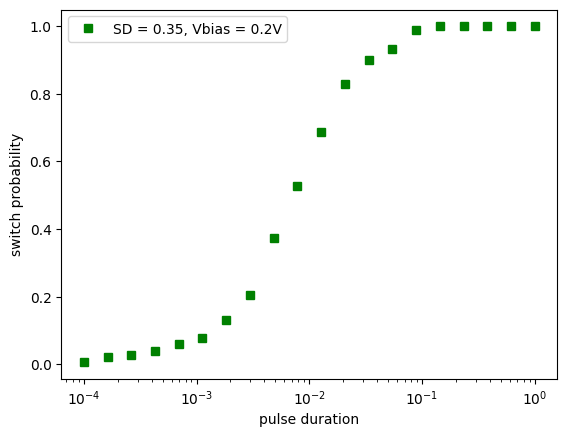

In [52]:
## code to find the probability plot

t_pulse = np.logspace(-4, 0, 20)
p = []
# choose one sd
print("sd = ", sd[0])
Ktime_sample = Ktime_sample_lst[0][0]
print(len(Ktime_sample))
for tp in t_pulse:
    prob = 0
    bit_sum = 0
    for i in range(len(Ktime_sample)):
        if(Ktime_sample[i] < tp):
            bit_sum += 1
        prob = bit_sum/len(Ktime_sample)
    p.append(prob)

plt.plot(t_pulse, p, "s", c = "green", label = "SD = 0.35, Vbias = 0.2V")
plt.xscale("log")
plt.xlabel("pulse duration")
plt.ylabel("switch probability")
plt.legend()
